In [6]:
# notebooks/image_classification_fine_tuning.ipynb

# --- 1. Import Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from tqdm import tqdm # For progress bars

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")


PyTorch Version: 2.7.0
Torchvision Version: 0.22.0


In [7]:
# --- 2. Setup Device (GPU or CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [8]:
# --- 3. Define Data Transformations ---
# For training: data augmentation and normalization
# For validation: only normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # ResNet and many others expect 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet stats
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
# --- 4. Load Data ---
# IMPORTANT: Update this path to where your 'cats_vs_dogs_small' dataset is
data_dir = '../data/cats_vs_dogs_subset' # Assuming notebook is in 'notebooks/' folder

# Check if data_dir exists
if not os.path.exists(data_dir):
    print(f"Error: Data directory '{data_dir}' not found.")
    print("Please download the cats vs. dogs dataset and place it in the correct directory structure:")
    print("  vision_classification_project/data/cats_vs_dogs_small/")
    print("    ├── train/")
    print("    │   ├── cats/")
    print("    │   └── dogs/")
    print("    └── validation/")
    print("        ├── cats/")
    print("        └── dogs/")
    # You might want to stop execution here if the data isn't found in a real script
    # For a notebook, this print statement will serve as a warning.
    # For now, we'll let it try to load and potentially fail if the path is wrong.
    
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'validation']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, # Adjust batch size based on your GPU memory
                                             shuffle=True, num_workers=2) # num_workers can speed up data loading
              for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")
print(f"Number of training batches: {len(dataloaders['train'])}")
print(f"Number of validation batches: {len(dataloaders['validation'])}")


Dataset sizes: {'train': 4001, 'validation': 1000}
Class names: ['cats', 'dogs']
Number of training batches: 251
Number of validation batches: 63


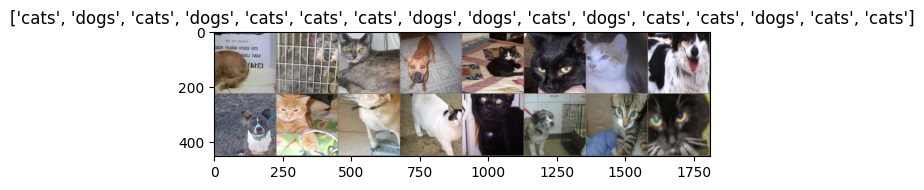

In [10]:
# --- 5. Visualize a few images (Optional) ---
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # Denormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
try:
    inputs, classes = next(iter(dataloaders['train']))
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])
    plt.show() # Ensure plot is displayed
except RuntimeError as e:
    if "No such file or directory" in str(e) or "Dataset not found" in str(e) :
        print(f"Could not load images, likely because the data directory '{data_dir}' is incorrect or empty.")
    else:
        raise e # Re-raise other RuntimeErrors

In [11]:
# --- 6. Define the Training Function ---
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # Wrap dataloader with tqdm for a progress bar
            progress_bar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}/{num_epochs}")
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar description
                if phase == 'train':
                    progress_bar.set_postfix(loss=loss.item(), acc=torch.sum(preds == labels.data).item()/inputs.size(0))


            if phase == 'train':
                scheduler.step() # Step the learning rate scheduler

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item()) # .item() to get Python number
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())


            # Deep copy the model if it's the best validation accuracy so far
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model
                if not os.path.exists('../models'):
                    os.makedirs('../models')
                torch.save(model.state_dict(), '../models/cats_dogs_best_model.pth')
                print("Saved new best model.")


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [12]:
# --- 7. Load a Pre-trained Model and Modify its Classifier ---
# We'll use ResNet18 as it's relatively small and quick to train.
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1) # Load with pre-trained weights

# Freeze all parameters in the feature extraction part
for param in model_ft.parameters():
    param.requires_grad = False

# Get the number of input features for the classifier
num_ftrs = model_ft.fc.in_features

# Replace the last fully connected layer (the classifier)
# The new fc layer will have parameters with requires_grad=True by default
model_ft.fc = nn.Linear(num_ftrs, len(class_names)) # len(class_names) should be 2 for cats/dogs

model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/utibeejike/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 28.5MB/s]


In [13]:
# --- 8. Define Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of the final layer are being optimized
# as opposed to before.
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)



In [14]:
# --- 9. Train the Model ---
# Ensure data has been loaded correctly before attempting to train
if 'train' in dataloaders and len(dataloaders['train']) > 0:
    print("Starting training...")
    model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) # Reduced epochs for quicker run
    # For a real run, you might use num_epochs=25 or more
else:
    print("Skipping training as data was not loaded properly or is empty.")
    history = None # Initialize history to None if training is skipped


Starting training...
Epoch 1/10
----------


Train Epoch 1/10: 100%|█████| 251/251 [01:52<00:00,  2.24it/s, acc=0, loss=1.02]


train Loss: 0.3022 Acc: 0.8650


Validation Epoch 1/10: 100%|████████████████████| 63/63 [00:35<00:00,  1.76it/s]


validation Loss: 0.0569 Acc: 0.9810
Saved new best model.

Epoch 2/10
----------


Train Epoch 2/10: 100%|█████| 251/251 [01:51<00:00,  2.25it/s, acc=0, loss=1.27]


train Loss: 0.2094 Acc: 0.9075


Validation Epoch 2/10: 100%|████████████████████| 63/63 [00:35<00:00,  1.75it/s]


validation Loss: 0.0544 Acc: 0.9880
Saved new best model.

Epoch 3/10
----------


Train Epoch 3/10: 100%|█████| 251/251 [01:54<00:00,  2.18it/s, acc=0, loss=1.05]


train Loss: 0.1868 Acc: 0.9155


Validation Epoch 3/10: 100%|████████████████████| 63/63 [00:37<00:00,  1.69it/s]


validation Loss: 0.0451 Acc: 0.9820

Epoch 4/10
----------


Train Epoch 4/10: 100%|████| 251/251 [02:03<00:00,  2.03it/s, acc=0, loss=0.835]


train Loss: 0.1888 Acc: 0.9173


Validation Epoch 4/10: 100%|████████████████████| 63/63 [00:38<00:00,  1.62it/s]


validation Loss: 0.0457 Acc: 0.9820

Epoch 5/10
----------


Train Epoch 5/10: 100%|█████| 251/251 [01:58<00:00,  2.13it/s, acc=0, loss=1.09]


train Loss: 0.2036 Acc: 0.9110


Validation Epoch 5/10: 100%|████████████████████| 63/63 [00:37<00:00,  1.68it/s]


validation Loss: 0.0469 Acc: 0.9820

Epoch 6/10
----------


Train Epoch 6/10: 100%|█████| 251/251 [01:57<00:00,  2.14it/s, acc=0, loss=1.78]


train Loss: 0.2092 Acc: 0.9083


Validation Epoch 6/10: 100%|████████████████████| 63/63 [00:38<00:00,  1.62it/s]


validation Loss: 0.0856 Acc: 0.9660

Epoch 7/10
----------


Train Epoch 7/10: 100%|████| 251/251 [02:03<00:00,  2.04it/s, acc=1, loss=0.461]


train Loss: 0.1889 Acc: 0.9130


Validation Epoch 7/10: 100%|████████████████████| 63/63 [00:37<00:00,  1.66it/s]


validation Loss: 0.0459 Acc: 0.9810

Epoch 8/10
----------


Train Epoch 8/10: 100%|████| 251/251 [01:55<00:00,  2.18it/s, acc=1, loss=0.685]


train Loss: 0.1614 Acc: 0.9275


Validation Epoch 8/10: 100%|████████████████████| 63/63 [00:35<00:00,  1.78it/s]


validation Loss: 0.0423 Acc: 0.9850

Epoch 9/10
----------


Train Epoch 9/10: 100%|████| 251/251 [01:51<00:00,  2.25it/s, acc=1, loss=0.583]


train Loss: 0.1789 Acc: 0.9230


Validation Epoch 9/10: 100%|████████████████████| 63/63 [00:36<00:00,  1.74it/s]


validation Loss: 0.0630 Acc: 0.9770

Epoch 10/10
----------


Train Epoch 10/10: 100%|███| 251/251 [01:49<00:00,  2.29it/s, acc=0, loss=0.794]


train Loss: 0.1730 Acc: 0.9265


Validation Epoch 10/10: 100%|███████████████████| 63/63 [00:36<00:00,  1.72it/s]

validation Loss: 0.0447 Acc: 0.9830

Training complete in 25m 28s
Best val Acc: 0.988000


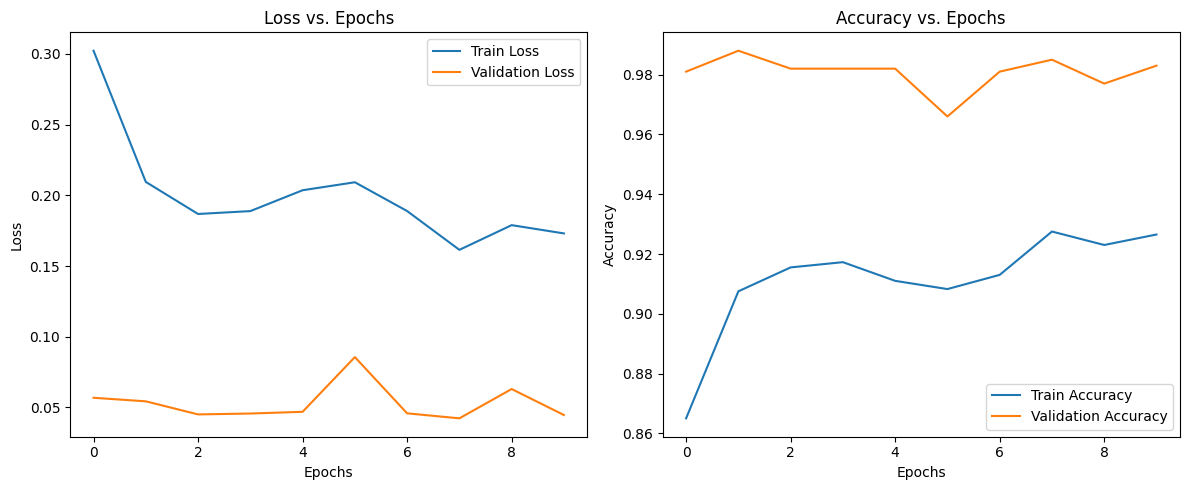

In [17]:
# --- 10. Plot Training History (Loss and Accuracy) ---
if history:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epochs')

    plt.subplot(1, 2, 2)
    # Convert tensor accuracies to float for plotting if they are not already
    train_acc_plot = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in history['train_acc']]
    val_acc_plot = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in history['val_acc']]
    
    plt.plot(train_acc_plot, label='Train Accuracy')
    plt.plot(val_acc_plot, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs. Epochs')
    plt.tight_layout()
    plt.show()
else:
    print("No training history to plot as training was skipped or failed.")


In [18]:
# --- 11. Further Steps (Optional - for you to explore) ---
# - Evaluate on a separate test set.
# - Make predictions on new images.
# - Experiment with different pre-trained models (ResNet34, ResNet50, VGG, EfficientNet).
# - Unfreeze more layers of the pre-trained model for full fine-tuning after initial classifier training.
# - More advanced data augmentation.
# - Hyperparameter tuning (learning rate, batch size, optimizer).
# - Use tools like TensorBoard or Weights & Biases for experiment tracking.